In [ ]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split

Resizing images:

Images are resized to 128x128 to increase speed but were not resized to much smaller size to retain information

In [2]:

scale_h,scale_w=32,32

for j in range(1,6):
    folder=f"dataset\\classes\\{j}"
    for i in range(1,21):
        path = f"{folder}\\{i}.png"
        image = cv2.imread(path)

        if image is None:
            print(f"Image at path {path} could not be loaded.")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        height, width = image_rgb.shape[1],image_rgb.shape[2]
        if height > scale_h or width > scale_w: 
            image_rgb = cv2.resize(image_rgb, (scale_h,scale_w))

        pil_image = Image.fromarray(image_rgb)
        pil_image.save(os.path.join(folder, f"{i}.png"))


Augmentation of images:

In [14]:
#random rotation of images 

def random_rotate(image, angle_range=(-15, 15)):
    angle = random.uniform(*angle_range)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    rotated_o = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return rotated_o

output_dir = "dataset\\rotated images"    
        
for j in range(1,6):
    folder_o=f"dataset\\classes\\{j}"
    
    save_dir_o=os.path.join(output_dir,str(j))
    os.makedirs(save_dir_o, exist_ok=True)
    
    for i in range(1,21):
        path_o = f"{folder_o}\\{i}.png"
        
        #reading image and corresponding ghibli
        image = cv2.imread(path_o,cv2.IMREAD_COLOR_RGB)
        
        rotated_img = random_rotate(image)

        pil_image = Image.fromarray(rotated_img)
        pil_image.save(os.path.join(save_dir_o, f"{i}.png"))
        

In [15]:
#randomly scaling images (cropping , down scaling)

def random_scale(image, scale_range=(0.9, 1.1)):
    h, w = image.shape[:2]
    scale = random.uniform(*scale_range)

    # Compute new size
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image
    scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Crop or pad to original size
    top = max((new_h - h) // 2, 0)
    bottom = max(h - new_h, 0) // 2
    left = max((new_w - w) // 2, 0)
    right = max(w - new_w, 0) // 2

    # Crop if scaled up
    if scale > 1.0:
        scaled = scaled[top:top + h, left:left + w]
        
    # Pad if scaled down
    else:
        scaled = cv2.copyMakeBorder(scaled, bottom, h - new_h - bottom, right, w - new_w - right, borderType=cv2.BORDER_REFLECT)
        
    return scaled


output_dir = "dataset\\scaled images"    

for j in range(1,6):
    folder_o=f"dataset\\classes\\{j}"
    
    save_dir_o=os.path.join(output_dir,str(j))
    os.makedirs(save_dir_o, exist_ok=True)
    
    for i in range(1,21):
        path_o = f"{folder_o}\\{i}.png"
        
        #reading image and corresponding ghibli
        image = cv2.imread(path_o,cv2.IMREAD_COLOR_RGB)
        
        
        scaled_img=random_scale(image)

        pil_image = Image.fromarray(scaled_img)
        pil_image.save(os.path.join(save_dir_o, f"{i}.png"))
     

In [16]:

def random_brightness_contrast(image, brightness_range=(-30, 30), contrast_range=(0.8, 1.2)):
    # Random brightness shift
    brightness = random.randint(*brightness_range)

    # Random contrast factor
    contrast = random.uniform(*contrast_range)

    # Convert image to float32 for accurate math
    img = image.astype(np.float32)
    
    # Apply contrast and brightness: new = image * contrast + brightness
    img = img * contrast + brightness
    
    # Clip values to [0, 255] and convert back to uint8
    img = np.clip(img, 0, 255).astype(np.uint8)
    

    return img


output_dir = "dataset\\contrast images"    

for j in range(1,6):
    folder_o=f"dataset\\classes\\{j}"
    
    save_dir_o=os.path.join(output_dir,str(j))
    os.makedirs(save_dir_o, exist_ok=True)
    
    for i in range(1,21):
        path_o = f"{folder_o}\\{i}.png"
        
        #reading image and corresponding ghibli
        image = cv2.imread(path_o,cv2.IMREAD_COLOR_RGB)
        
        
        img=random_brightness_contrast(image)

        pil_image = Image.fromarray(img)
        pil_image.save(os.path.join(save_dir_o, f"{i}.png"))
        

In [ ]:
#ANN with 2 hidden layers

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(a):
    return (a > 0).astype(float)

def initialize_parameters(input_size, hidden_sizes, output_size):
    np.random.seed(1)
    W1 = np.random.randn(input_size, hidden_sizes[0]) * 0.01
    b1 = np.zeros((1, hidden_sizes[0]))
    W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01
    b2 = np.zeros((1, hidden_sizes[1]))
    W3 = np.random.randn(hidden_sizes[1], output_size) * 0.01
    b3 = np.zeros((1, output_size))

    return {
        "W1": W1, "b1": b1,
        "W2": W2, "b2": b2,
        "W3": W3, "b3": b3
    }

def forward_pass(X, params, apply_dropout, is_training, keep_prob=0.8):
    Z1 = np.dot(X, params["W1"]) + params["b1"]
    A1 = relu(Z1)
    if apply_dropout and is_training:
        dropout1 = (np.random.rand(*A1.shape) < keep_prob).astype(float)
        A1 *= dropout1
    else:
        A1 *= keep_prob

    Z2 = np.dot(A1, params["W2"]) + params["b2"]
    A2 = relu(Z2)
    if apply_dropout and is_training:
        dropout2 = (np.random.rand(*A2.shape) < keep_prob).astype(float)
        A2 *= dropout2
    else:
        A2 *= keep_prob

    Z3 = np.dot(A2, params["W3"]) + params["b3"]
    A3 = softmax(Z3)

    cache = {
        "A1": A1, "Z1": Z1, "dropout1": dropout1 if apply_dropout else None,
        "A2": A2, "Z2": Z2, "dropout2": dropout2 if apply_dropout else None,
        "A3": A3, "Z3": Z3
    }
    return A3, cache

def compute_loss(y_true, y_pred):
    eps = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

def compute_accuracy(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred_labels == y_true_labels) * 100

def backward_pass(X, y, cache, params, learning_rate, keep_prob=1.0):
    m = X.shape[0]
    A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]

    dZ3 = A3 - y
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    dA2 = np.dot(dZ3, params["W3"].T)
    dA2 *= relu_derivative(A2)
    if cache["dropout2"] is not None:
        dA2 *= cache["dropout2"]

    dW2 = np.dot(A1.T, dA2) / m
    db2 = np.sum(dA2, axis=0, keepdims=True) / m

    dA1 = np.dot(dA2, params["W2"].T)
    dA1 *= relu_derivative(A1)
    if cache["dropout1"] is not None:
        dA1 *= cache["dropout1"]

    dW1 = np.dot(X.T, dA1) / m
    db1 = np.sum(dA1, axis=0, keepdims=True) / m

    params["W3"] -= learning_rate * dW3
    params["b3"] -= learning_rate * db3
    params["W2"] -= learning_rate * dW2
    params["b2"] -= learning_rate * db2
    params["W1"] -= learning_rate * dW1
    params["b1"] -= learning_rate * db1


def train(X, y, hidden_sizes=[128, 64], output_size=5, epochs=100, learning_rate=0.1, keep_prob=0.8, patience=5):
    input_size = X.shape[1]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)

    params = initialize_parameters(input_size, hidden_sizes, output_size)

    best_loss = float("inf")
    wait = 0
    history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        
        y_pred, cache = forward_pass(X_train, params, apply_dropout=True, is_training=True, keep_prob=keep_prob)
        loss = compute_loss(y_train, y_pred)
        acc = compute_accuracy(y_train, y_pred)
        backward_pass(X_train, y_train, cache, params, learning_rate, keep_prob)

        val_pred, _ = forward_pass(X_val, params, apply_dropout=False, is_training=False)
        val_loss = compute_loss(y_val, val_pred)
        val_acc = compute_accuracy(y_val, val_pred)

        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f} , val Loss: {val_loss:.4f} , acc: {acc:.4f} , val acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    return params, history

def test(X, params):
    y_pred, _ = forward_pass(X, params, apply_dropout=False, is_training=False)
    return y_pred


In [10]:
def plot_history(training_loss,v_test_loss,training_acc,v_test_acc):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Train Loss')
    plt.plot(v_test_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    #accuracy
    plt.subplot(1,2,2)
    plt.plot(training_acc, label='Train accuracy')
    plt.plot(v_test_acc, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy Curve')
    plt.legend()

    plt.show()

In [11]:
def extract_simple_features(image):
    image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image=image.flatten()
    image=image/255.0
    return image

DATASET IMAGES:

In [85]:
labels=["yasir","cheema","arslan","ahmed","ebad"]

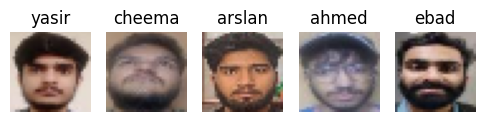

In [86]:
#sample of training images

def plot_images(training_images,labels, img_index, fig_len):
    fig = plt.figure(figsize=(6, 6))
    j = img_index
    
    for i in range(fig_len):
        ax = fig.add_subplot(2, fig_len, i + 1)
        ax.imshow(training_images[j])
        ax.axis('off')
        ax.set_title(labels[j])
        j += 1
images=[]

for j in range(1,6):
    folder_o=f"dataset\\classes\\{j}"
    
    for i in range(1,2):
        path_o = f"{folder_o}\\{i}.png"
        
        #reading image
        image_o = cv2.imread(path_o,cv2.IMREAD_COLOR_RGB)
        images.append(image_o)
        
plot_images(training_images=images,labels=labels,img_index=0,fig_len=5)

In [ ]:
X_train_o,y_train,X_train_g=[],[],[]

X_train_r,X_train_rg=[],[]

X_train_s,X_train_sg=[],[]

for j in range(1,6):
    
    folder_o=f"dataset\\classes\\{j}"
    
    folder_r=f"dataset\\rotated images\\{j}"
    
    folder_s=f"dataset\\scaled images\\{j}"
    
    
    for i in range(1,21):
        path_o = f"{folder_o}\\{i}.png"
        
        path_r = f"{folder_r}\\{i}.png"
        
        path_s = f"{folder_s}\\{i}.png"
        
        
        image_o = cv2.imread(path_o,cv2.IMREAD_COLOR_RGB)
        
        image_r = cv2.imread(path_r,cv2.IMREAD_COLOR_RGB)
        
        image_s = cv2.imread(path_s,cv2.IMREAD_COLOR_RGB)

        #extracting the  features of images and their corresponding ghiblis
        
        features_o=extract_simple_features(image_o)

        features_r=extract_simple_features(image_r)

        features_s=extract_simple_features(image_s)

       
        #storing particular features
        X_train_o.append(features_o)

        X_train_r.append(features_r)

        X_train_s.append(features_s)

        #one hot-encoded vector        
        new_labels=[0]*len(labels)
      
        label_idx = j - 1  
        new_labels[label_idx] = 1
        
        y_train.append(new_labels)


In [26]:
#converting to numpy arrays
X_train=[X_train_o,X_train_r,X_train_s]
for i in range(len(X_train)):
    X_train[i]=np.array(X_train[i])


y_train=np.array(y_train)

In [27]:
#concatenating all images,labels into one array
X_total = np.concatenate(X_train)
y_total = np.concatenate([y_train] * len(X_train), axis=0) 

In [28]:
print(X_total.shape)
print(y_total.shape)

(255, 1024)
(255, 5)


In [93]:
X_train,X_test,y_train,y_test=train_test_split(X_total,y_total,test_size=0.2,random_state=42)

In [94]:
X_train=(X_train-np.mean(X_train))/np.std(X_train)

In [95]:
params, history = train(X_train, y_train, hidden_sizes=[512,128], epochs=1000, learning_rate=0.01, keep_prob=0.8, patience=5)

Epoch 0, Loss: 1.6089 , val Loss: 1.6091360700404282 , acc: 26.380368098159508 , val acc: 24.390243902439025
Epoch 100, Loss: 1.6033 , val Loss: 1.6053199794873207 , acc: 23.31288343558282 , val acc: 19.51219512195122
Epoch 200, Loss: 1.5908 , val Loss: 1.595462694736156 , acc: 30.67484662576687 , val acc: 21.951219512195124
Epoch 300, Loss: 1.5427 , val Loss: 1.55424259491158 , acc: 58.282208588957054 , val acc: 56.09756097560976
Epoch 400, Loss: 1.3311 , val Loss: 1.373935628489201 , acc: 41.104294478527606 , val acc: 46.34146341463415
Epoch 500, Loss: 1.0902 , val Loss: 1.1284972309119266 , acc: 51.533742331288344 , val acc: 53.65853658536586
Epoch 600, Loss: 0.8459 , val Loss: 0.9072980261677883 , acc: 65.03067484662577 , val acc: 58.536585365853654
Epoch 700, Loss: 0.6225 , val Loss: 0.7210306692551895 , acc: 77.91411042944786 , val acc: 68.29268292682927
Epoch 800, Loss: 0.4621 , val Loss: 0.5812903842769928 , acc: 90.1840490797546 , val acc: 87.8048780487805
Epoch 900, Loss: 0.3

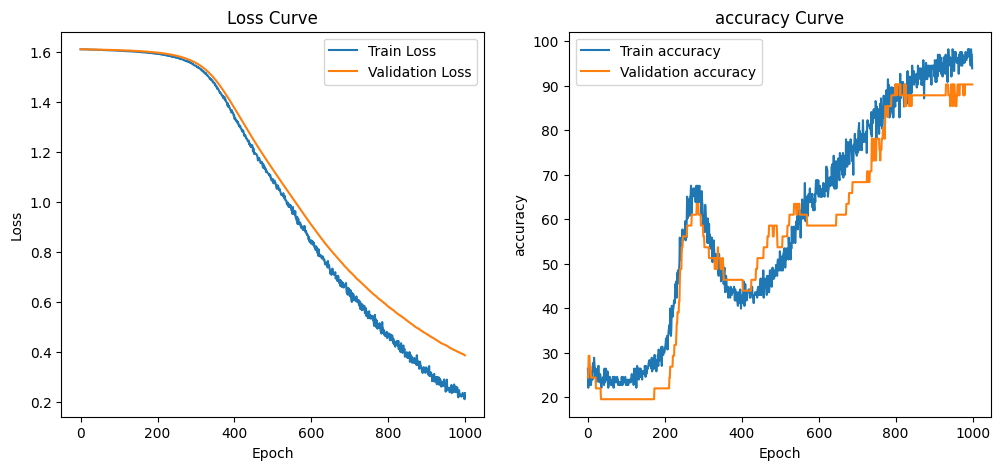

In [96]:
plot_history(history['loss'],history['val_loss'],history['acc'],history['val_acc'])

In [97]:
#save weights and biases in a .npz file

np.savez("model_weights.npz", **params)


In [98]:
#load weights before testing

loaded_weights=np.load("model_weights.npz")
params={key: loaded_weights[key] for key in loaded_weights}

In [99]:
X_test=(X_test-np.mean(X_test))/np.std(X_test)

In [100]:
y_pred=test(X_test,params)

In [101]:
#computing test accuracy
test_acc=compute_accuracy(y_test,y_pred)
print(f"test accuracy: {test_acc:.4f}")

test accuracy: 90.1961
